In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bayusulistiyawan","key":"ac683652beff2450b83ea3404d402ca1"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d madisona/translated-animals10

!mkdir animals
!unzip -qq translated-animals10.zip -d animals
!ls animals

 98% 576M/586M [00:02<00:00, 206MB/s]
100% 586M/586M [00:03<00:00, 200MB/s]
animals10


In [4]:
!ls animals/animals10/raw-img/

butterfly  cat	chicken  cow  dog  elephant  horse  sheep  spider  squirrel


In [5]:
import os

animals = os.path.join('/content/animals/animals10/raw-img/')

print(os.listdir(animals))

['squirrel', 'sheep', 'chicken', 'elephant', 'dog', 'cat', 'butterfly', 'cow', 'horse', 'spider']


In [6]:
import shutil

ignore_animals = ['squirrel','sheep','cat', 'elephant', 'cow','horse']

for x in ignore_animals:
  path = os.path.join(animals, x)
  shutil.rmtree(path)

In [7]:
list_animals = os.listdir(animals)
print(list_animals)

['chicken', 'dog', 'butterfly', 'spider']


In [8]:
from PIL import Image
total = 0

for x in list_animals:
  dir = os.path.join(animals, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal :', total)

chicken: 3098
- (300, 225)
- (300, 225)
- (300, 225)
- (300, 225)
---------------
dog: 4863
- (300, 294)
- (300, 264)
- (299, 300)
- (300, 251)
---------------
butterfly: 2112
- (640, 428)
- (300, 225)
- (640, 426)
- (300, 169)
---------------
spider: 4821
- (300, 235)
- (277, 300)
- (300, 240)
- (300, 199)
---------------

Total : 14894


<function matplotlib.pyplot.show>

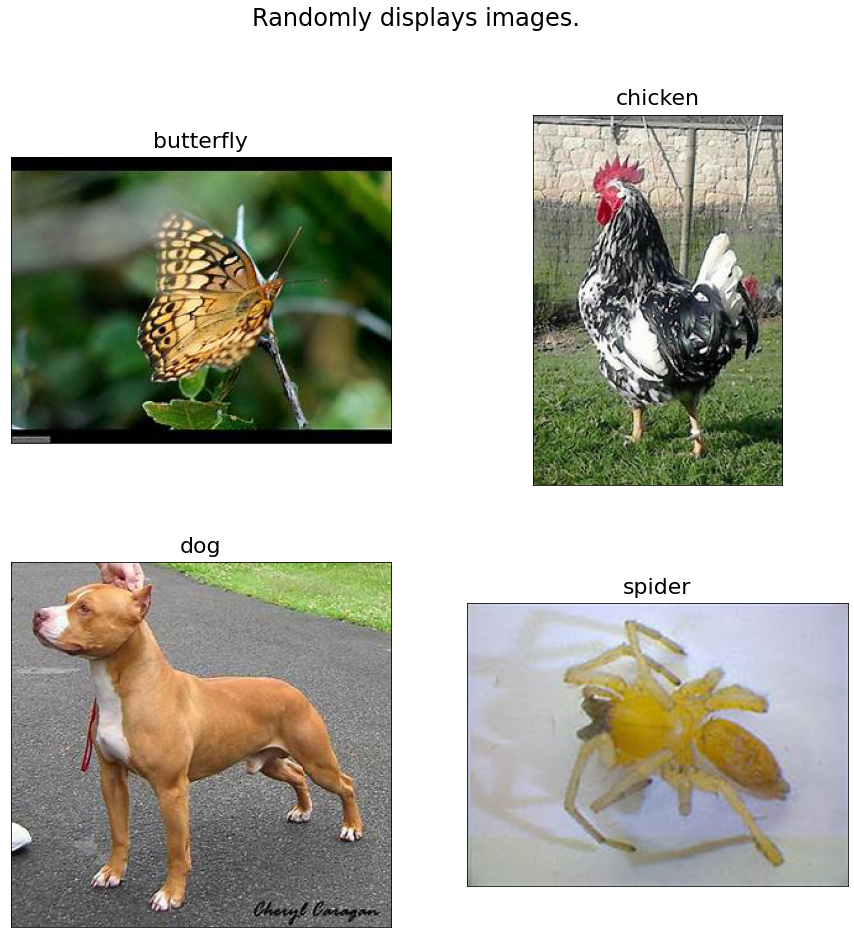

In [9]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle("Randomly displays images.", fontsize=24)
animals_sorted = sorted(list_animals)
animals_id = 0
for i in range(2):
  for j in range(2):
    try:
      animals_selected = animals_sorted[animals_id] 
      animals_id += 1
    except:
      break
    if animals_selected == '.TEMP':
        continue
    animals_selected_images = os.listdir(os.path.join(animals, animals_selected))
    animals_selected_random = np.random.choice(animals_selected_images)
    img = plt.imread(os.path.join(animals, animals_selected, animals_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(animals_selected, pad=10, fontsize=22)
    
plt.setp(ax, xticks=[],yticks=[])
plt.show

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   
)

In [11]:
batch_size = 256

data_train = train_datagen.flow_from_directory(
    animals,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

data_val = train_datagen.flow_from_directory(
    animals, 
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 11917 images belonging to 4 classes.
Found 2977 images belonging to 4 classes.


In [12]:
import tensorflow as tf
# from tensorflow.keras import applications, optimizers

tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAccuracy above 92%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

In [14]:
history = model.fit(data_train, 
                    epochs = 100, 
                    steps_per_epoch = data_train.samples // batch_size,
                    validation_data = data_val, 
                    validation_steps = data_val.samples // batch_size,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/100
46/46 [==============================] - 116s 2s/step - loss: 1.3042 - accuracy: 0.3857 - val_loss: 1.1599 - val_accuracy: 0.4624
Epoch 2/100
46/46 [==============================] - 81s 2s/step - loss: 1.1053 - accuracy: 0.5112 - val_loss: 1.0699 - val_accuracy: 0.5437
Epoch 3/100
46/46 [==============================] - 81s 2s/step - loss: 0.9817 - accuracy: 0.5891 - val_loss: 0.9501 - val_accuracy: 0.6062
Epoch 4/100
46/46 [==============================] - 80s 2s/step - loss: 0.8583 - accuracy: 0.6547 - val_loss: 0.8101 - val_accuracy: 0.6893
Epoch 5/100
46/46 [==============================] - 81s 2s/step - loss: 0.7788 - accuracy: 0.6971 - val_loss: 0.7647 - val_accuracy: 0.6882
Epoch 6/100
46/46 [==============================] - 80s 2s/step - loss: 0.7331 - accuracy: 0.7112 - val_loss: 0.7254 - val_accuracy: 0.7180
Epoch 7/100
46/46 [==============================] - 80s 2s/step - loss: 0.6753 - accuracy: 0.7401 - val_loss: 0.6460 - val_accuracy: 0.7628
Epoch 8/100


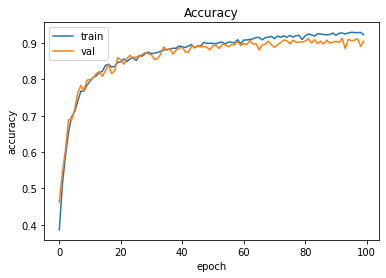

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

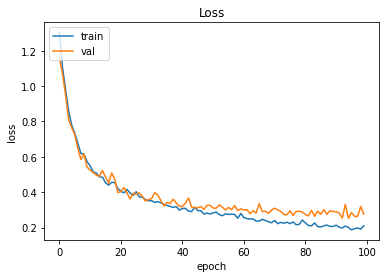

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfkuh398t/assets


In [19]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root  13900684 Jun 27 15:35 model.tflite
